In [197]:
zero_cutoff = 0.02
differential = True
hdlc = True
decimate_by = 2
dataFile = 'sanosat1bcut.wav'


[0.         0.         0.         ... 0.17391968 0.27072144 0.261261  ]
65191


C:\Users\Saurav\AppData\Local\Temp\ipykernel_30368\278407009.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, rf = wf.read(dataFile)


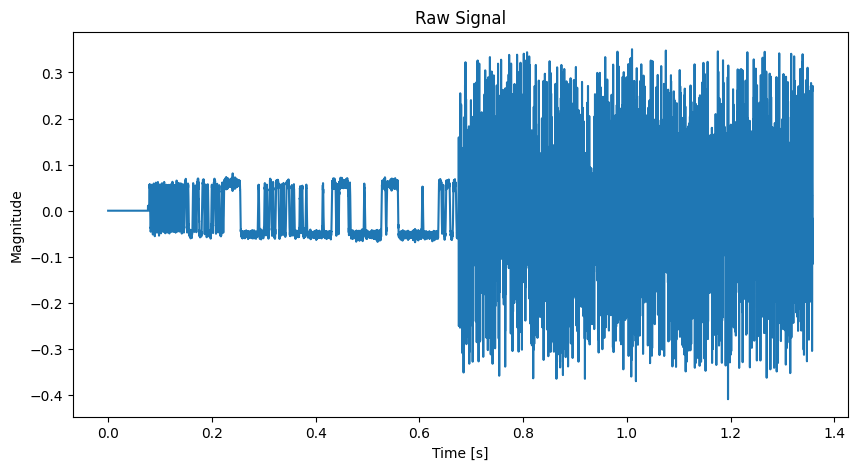

In [198]:
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import math
import sys

plt.rcParams['figure.figsize'] = [10, 5]
#
# DATA LOAD
#

# read the wave file
# Data6 shows a need for bit stuffing
# fs, rf = wf.read('data6-aq.wav') 
# Data7 makes sure to flip more often 
# fs, rf = wf.read('data7-aq.wav')
# Data8 has differential encoding and bit inversion
fs, rf = wf.read(dataFile)

sf = {
    np.dtype('int16'): 2**15,
    np.dtype('int32'): 2**32,
    np.dtype('float32'): 1,
    np.dtype('float64'): 1,
}[rf.dtype]

rf = (rf[:]) / sf
# rf = (rf[:, 0] + rf[:, 1]) / sf


print(rf)
print(len(rf))

# plt.subplot(1, 2, 1)
plt.title('Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(rf)) / fs, rf)


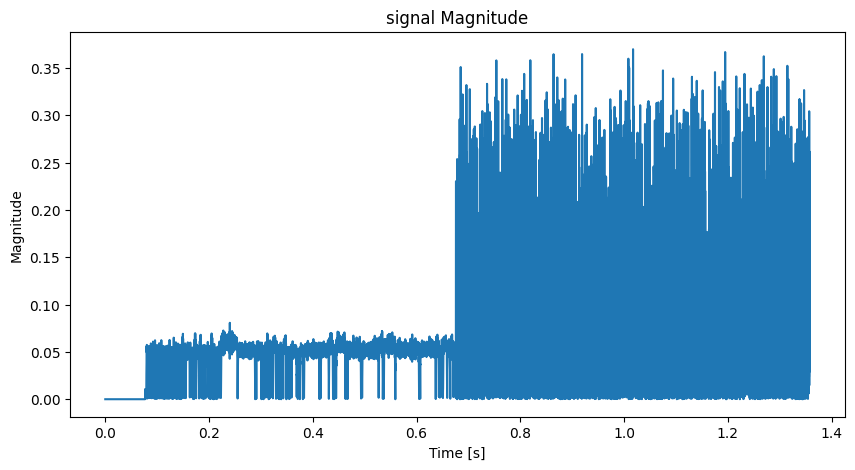

In [199]:
# Decimate the data to make processing simpler
fs = fs // decimate_by
rf = rf[::decimate_by]

# Thanks to Tomasz for a lot of inspiration
# https://mightydevices.com/index.php/2019/08/decoding-fsk-transmission-recorded-by-rtl-sdr-dongle/
audio_mag = np.abs(rf)
plt.title('signal Magnitude')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(audio_mag)) / fs, audio_mag)

In [200]:

data_start_threshold = 0.1

a = np.array([5, 4, 2, 0, 4, -1, -2, 3, 1, 5])
print('a:',a)
a_mag=np.abs(a)
print('absa:',a_mag)
a_indices = np.nonzero( a_mag< 3)[0]

print('a_indices',a_indices)
a_f = a[np.min(a_indices) : np.max(a_indices)]
print('s',a_f)
# indices with magnitude higher than threshold



a: [ 5  4  2  0  4 -1 -2  3  1  5]
absa: [5 4 2 0 4 1 2 3 1 5]
a_indices [2 3 5 6 8]
s [ 2  0  4 -1 -2  3]


audio_indices: [    0     1     2 ... 32592 32593 32594]
[ 0.          0.          0.         ... -0.0479126  -0.03161621
 -0.02926636]


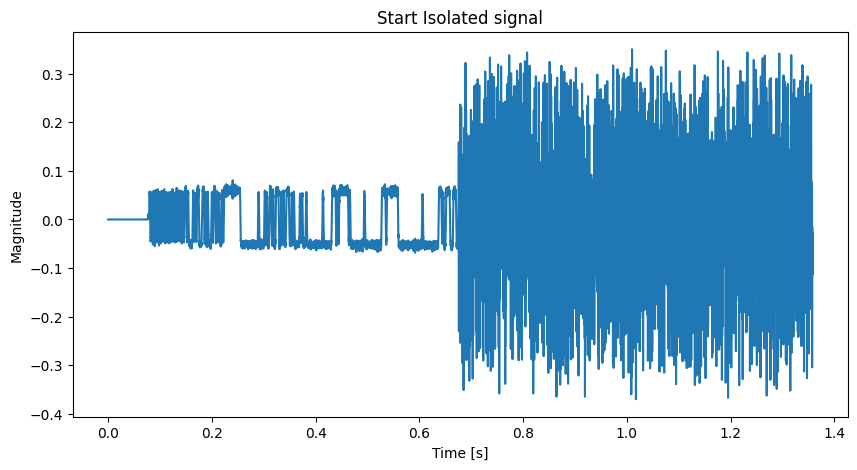

In [201]:
audio_indices = np.nonzero(audio_mag < 0.2)[0]
# limit the signal
print('audio_indices:',audio_indices)
audio = rf[np.min(audio_indices) : np.max(audio_indices)]

print(audio)
plt.title('Start Isolated signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(audio)) / fs, audio)

[ 0.          0.          0.         ... -0.06591797 -0.0479126
 -0.03161621]


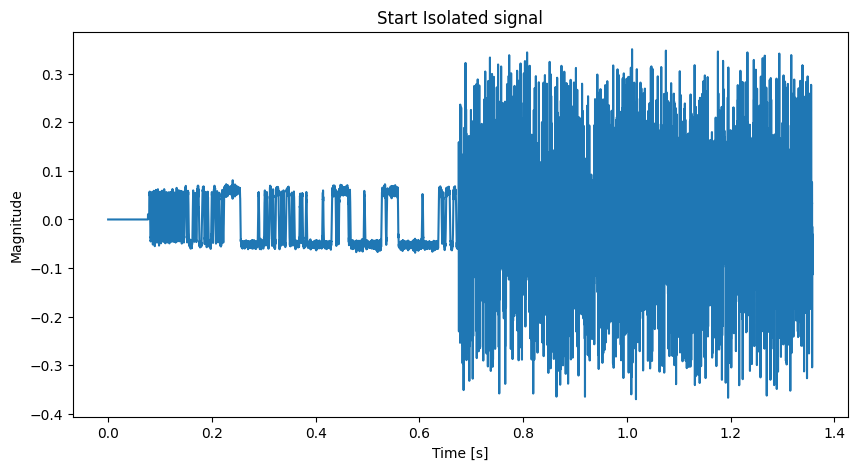

In [202]:
audio_indices = np.nonzero(audio_mag < 0.1)[0]
# limit the signal
audio = rf[np.min(audio_indices) : np.max(audio_indices)]

print(audio)
plt.title('Start Isolated signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(audio)) / fs, audio)

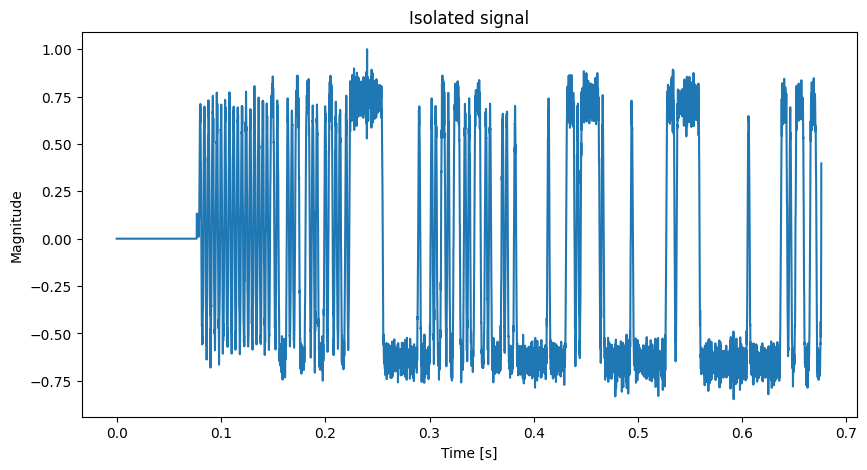

In [203]:

audio_mag = np.abs(audio)
# Again, use the max of the first quarter of data to find the end (noise)
data_end_threshold = np.max(audio_mag[:round(len(audio_mag)/4)])*1.05

audio_indices = np.nonzero(audio_mag > data_end_threshold)[0]
# Use the data not found above and normalize to the max found
if len(audio_indices) > 0:
    audio = audio[ : np.min(audio_indices)] / (data_end_threshold/1.05)

# plt.subplot(1, 2, 2)
plt.title('Isolated signal')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.plot(np.arange(0, len(audio)) / fs, audio)

samples_per_bit 48
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0
 0]


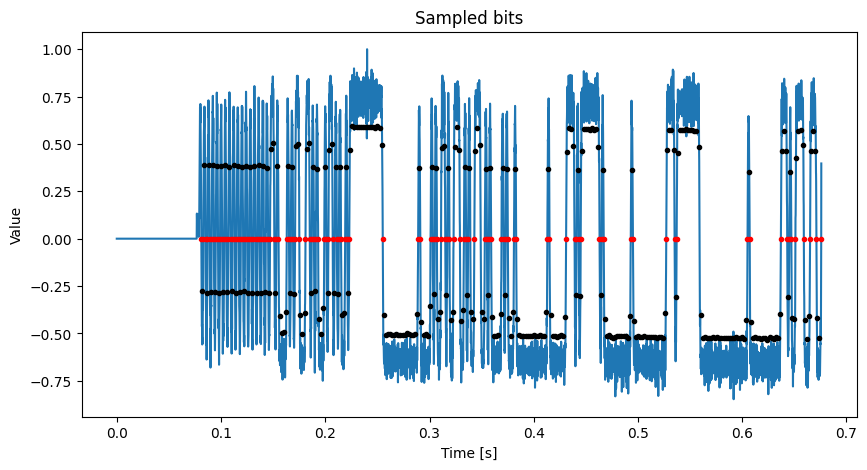

In [206]:
'''
This next chunk finds all the zero crossings, bit rate and bits
'''
zero_cross = [] 
for i in range(len(audio)):
#     print(audio[i-1])
    if audio[i -1] < 0 and audio[i] > 0:
        zero_cross += [(i, (audio[i -1]+audio[i])/2)]
    if audio[i -1] > 0 and audio[i] < 0:
        zero_cross += [(i, (audio[i -1]+audio[i])/2)]

# Get the first 10 zero crossings, ignoring the first as it may be offset
first_ten = zero_cross[1:11]

samples_per_bit = first_ten[len(first_ten)-1][0] - first_ten[0][0]
samples_per_bit = samples_per_bit/(len(first_ten)-1)
samples_per_bit_raw = samples_per_bit

# We will be using this to index arrays, so lets floor to the nearest integer
samples_per_bit = math.floor(samples_per_bit)
print('samples_per_bit',samples_per_bit)
sampled_bits = []
bits = []
# Let's iterate over the chunks of data between zero crossings
for i in range(len(zero_cross))[:-1]:
    # Now let's iterate over the bits within the zero crossings
    # Note, let's add an extra 1/8th of a sample just in case
    for j in range(math.floor((zero_cross[i+1][0]-zero_cross[i][0] + samples_per_bit/8 )/samples_per_bit)):
        # Let's offset by 1 sample in case we catch the rising and falling edge
        start = zero_cross[i][0]+j*samples_per_bit+1
        end =   zero_cross[i][0]+j*samples_per_bit+samples_per_bit-1
        sampled_bits += [(zero_cross[i][0]+j*samples_per_bit+samples_per_bit/2, np.average(audio[start:end]))]
        bits += [np.average(audio[start:end]) >= zero_cutoff *1]

# Let's convert the true/false data into uint8s for later use
bits = (np.array(bits)).astype(np.uint8)

print(bits)

Bits = bits

# plt.subplot(2, 2, 3)
plt.title('Sampled bits')
plt.xlabel('Time [s]')
plt.ylabel('Value')
plt.plot(np.arange(0, len(audio)) / fs, audio)
plt.plot([(x[0]-.5) / fs for x in zero_cross], [0 for x in zero_cross], ".r")
plt.plot([(x[0]) / fs for x in sampled_bits], [x[1]*.8 for x in sampled_bits], ".k")

Raw data [45, 212, 88, 209, 74, 255, 255, 0, 0, 130, 178, 156, 114, 10, 138, 0, 128, 0, 175, 255, 2, 128, 0, 0, 239, 255, 0, 0, 128, 0, 128, 203, 227]
As hex 2d d4 58 d1 4a ff ff 00 00 82 b2 9c 72 0a 8a 00 80 00 af ff 02 80 00 00 ef ff 00 00 80 00 80 cb e3: 


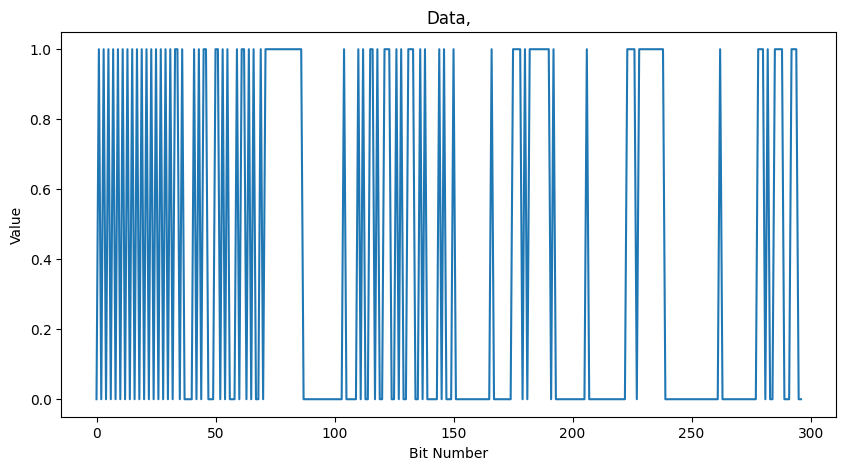

In [207]:
'''
Now let's extract the raw data
'''

bits = Bits

# https://pysdr.org/content/rds.html#differential-decoding
#bits = (bits[1:] - bits[0:-1]) % 2
#bits = bits.astype(np.uint8)

current_data = 0
start_data_offset = 0
data = []
found_start = False
for b in range(len(bits)):
    bit = bits[b]
    # Each byte is sent in order but the bits are sent reverse order
    current_data = current_data >> 1
    current_data += (bit*0x80)
    current_data &= 0xff

    # We've already found the start flag, time to store each byte
    if found_start:
        if ((b - start_data_offset) % 8) == 0:  
            data.append(current_data)
            current_data = 0
        continue

    # Have we found the flag? 0x7E
    if(current_data == 0b00101101) and b > 4 and not found_start:
        found_start = True
        start_data_offset = b
        data.append(0x2D)
        current_data = 0
    if(current_data == 0b10110100) and b > 4 and not found_start:
        found_start = True
        start_data_offset = b
        data.append(0xB4)
        # Invert the bit value since we found an inverted flag
        bits = (np.array([x for x in bits]) < 1 ).astype(np.uint8)
        current_data = 0


print("Raw data %s" % data)
hex_string = " ".join("%02x" % b for b in data)
print("As hex %s: " % hex_string)


# plt.subplot(2, 2, 4)
plt.title('Data,')
plt.xlabel('Bit Number')
plt.ylabel('Value')
plt.plot(bits)

plt.show()